In [1]:
from copy import copy
from datetime import datetime
from collections import namedtuple
import numpy as np
import plotter as pltr
pltr.set_backend(pltr.MatplotlibBackend)

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.utils.data as dutils
import torch.optim as optim
import torch.nn.functional as F

## Utility Functions

In [3]:
means = [0.5]
stds = [0.5]
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

white = pltr.Color(red=255, green=255, blue=255)
big_white_font = pltr.Font(color=white, size=14)

Metric = namedtuple('Metric', ['name', 'train', 'val'])

def tensor2img(tensor):
    """
    Tensor of size 1xHxW: Supposed to be an image with a single channel
    Returns an ndarray of shape HxW of type int with values between 0 and 255.
    """
    img = copy(tensor.cpu().detach().numpy())
    img = img.squeeze()  # Get rid fo the single channel dim
    img = img * stds + means  # De-normalize
    img = np.clip(img, 0, 1)
    img = 255 * img  # Re-scale to 0-255
    img = img.astype(np.int)
    return img

def show_imgs(imgs, titles):
    """
    imgs: list of ndarrays of shape HxW
    titles: list of strings
    """
    frame = pltr.Frame()
    frame.layout(1, len(imgs))  # Show all the images in a single row
    for img, title in zip(imgs, titles):
        chart = frame.create_chart()
        chart.title = title
        chart.title_font = big_white_font
        chart.show_axes = False
        imgplot = pltr.GrayscaleImage(img)
        chart.add(imgplot)
    frame.show()
    
def show_classification(img: np.ndarray, label: str, probs: np.ndarray):
    """
    img: ndarray of shape HxW. Supposed to be a grayscale image
    probs: ndarray of shape K. Supposed to be the probability of each class
    """
    frame = pltr.Frame()
    frame.layout(1, 2)
    
    # Image chart
    chart = frame.create_chart()
    chart.title = label
    chart.title_font = big_white_font
    chart.show_axes = False
    imgplot = pltr.GrayscaleImage(img)
    chart.add(imgplot)
    
    # Probs plot
    chart = frame.create_chart()
    chart.title = 'Class Probabilities'
    chart.title_font = big_white_font
    chart.x_axis.limits = (0, 1)
    chart.x_axis.font = pltr.Font(color=white)
    chart.y_axis.font = pltr.Font(color=white)
    cats = [str(v) for v in range(len(probs))]
    probsplot = pltr.HorizontalBar(categories=cats, values=probs)
    chart.add(probsplot)
    
    frame.show()
    
def plot_learning_curves(*metrics):
    frame = pltr.Frame(height_px=1100, width_px=2000)
    frame.layout(len(metrics), 1)
    train_color = pltr.Color(red=7, green=87, blue=124)
    val_color = pltr.Color(red=124, green=7, blue=87)
    for metric in metrics:
        chart = frame.create_chart()
        chart.title = metric.name.upper()
        chart.title_font = big_white_font
        chart.x_axis = pltr.Axis(label='Epochs', font=pltr.Font(color=white))
        chart.y_axis.font = pltr.Font(color=white)
        chart.legend_location = pltr.LegendLocation.BEST
        
        epochs = [str(i) for i in range(len(metric.train))]
        
        train_line = pltr.Line(categories=epochs, values=metric.train, legend='Train', color=train_color)
        chart.add(train_line)
        
        val_line = pltr.Line(categories=epochs, values=metric.val, legend='Val', color=val_color)
        chart.add(val_line)
    frame.show()

## Load Images

### View without any transforms

In [4]:
traindata = datasets.MNIST('/data/pytorch/mnist/', download=True, train=True)
traindata[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x10C0A6550>, tensor(5))

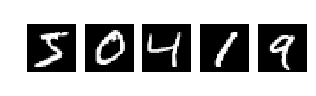

In [5]:
titles = []
imgs = []
for i in range(5):
    pil_img, label = traindata[i]
    imgs.append(np.array(pil_img))
    titles.append(str(label.item()))
show_imgs(imgs, titles)

### With transforms

In [6]:
xforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])
traindata = datasets.MNIST('/data/pytorch/mnist', download=True, train=True, transform=xforms)
train_size = int(0.8*(len(traindata)))
val_size = len(traindata) - train_size
trainset, valset = dutils.random_split(traindata, (train_size, val_size))
print(type(trainset))
print(type(trainset[0]))

train_image, train_label = trainset[0]
print(train_image.size())
print(train_label)
val_image, val_label = valset[0]
print(val_image.size())
print(val_label)

<class 'torch.utils.data.dataset.Subset'>
<class 'tuple'>
torch.Size([1, 28, 28])
tensor(6)
torch.Size([1, 28, 28])
tensor(9)


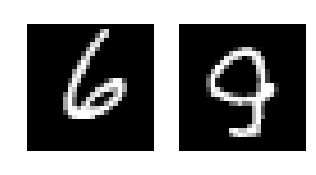

In [7]:
imgs = [tensor2img(train_image), tensor2img(val_image)]
titles = [str(train_label.item()), str(val_label.item())]
show_imgs(imgs, titles)

In [8]:
trainloader = dutils.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = dutils.DataLoader(valset, batch_size=64, shuffle=True)

## CNN

#### Layer 1
28x28x1 → CONV(5, ch=10) → 24x24x10 → MAXPOOL(2) → 12x12x10 → RELU → 12x12x10
####   
#### Layer 2
12x12x10 → CONV(5, ch=20) → 8x8x20 → DROPOUT → 8x8x20 → MAXPOOL(2) → 4x4x20 → RELU → 4x4x20
####  
#### Layer 3
4x4x20 → FLATTEN → 320 → LINEAR(320, 50) → 50 → RELU → 50 → DROPOUT → 50
####  
#### Layer 4
50 → LINEAR(50, 10) → 10 → LOG-SOFTMAX → 10

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(F.dropout(self.conv2(x), training=self.training), 2))
        x = F.dropout(F.relu(self.fc1(x.view(-1, 320))), training=self.training)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [10]:
# Train single batch
model = Net()
model = model.to(DEVICE)
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

start = datetime.now()
images, labels = next(iter(trainloader))
images = images.to(DEVICE)
labels = labels.to(DEVICE)
with torch.enable_grad():
    optimizer.zero_grad()
    log_probs = model.forward(images)
    loss = loss_fn(log_probs, labels)
    loss.backward()
    optimizer.step()
    
    batch_loss = loss.item() * images.size(0)
    preds = torch.argmax(log_probs, dim=1)
    batch_acc = torch.sum(preds == labels.data)
end = datetime.now()
elapsed = end - start
print(f'Time taken for single batch: {elapsed}')
print(f'Loss: {batch_loss:.3f}\tAccuracy: {batch_acc.double()/images.size(0):.3f}')

Time taken for single batch: 0:00:00.046743
Loss: 147.879	Accuracy: 0.078


torch.Size([1, 10])


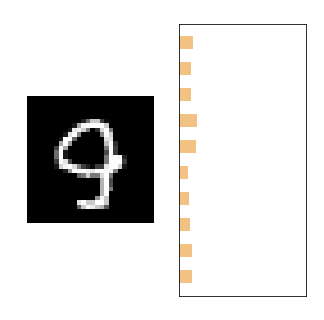

In [11]:
# Lets see how the model performs on the val image
# First create a batch of 1
image = val_image.view(1, 1, 28, 28).to(DEVICE)
log_probs = model.forward(image)
print(log_probs.size())  # Should be 1x10
probs = torch.exp(log_probs)

img = tensor2img(val_image)
title = str(val_label.item())
probs = probs.cpu().detach().numpy().flatten()
show_classification(img, title, probs)

In [14]:
# Train
model = Net()
model = model.to(DEVICE)
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 3
losses = Metric(name='loss', train=[], val=[])
accuracies = Metric(name='Accuracy', train=[], val=[])
model.train()
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    start = datetime.now()
    train_epoch_loss = 0.0
    train_epoch_acc = 0
    for batch, (images, labels) in enumerate(trainloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.enable_grad():
            optimizer.zero_grad()
            log_probs = model.forward(images)
            loss = loss_fn(log_probs, labels)
            loss.backward()
            optimizer.step()
#             print(f'Batch {batch} Grads after step: {model.fc2.weight.grad[0, :5]}')
            batch_loss = loss * images.size(0)
            preds = torch.argmax(log_probs, dim=1)
            batch_acc = torch.sum(preds == labels)
            train_epoch_loss += batch_loss
            train_epoch_acc += batch_acc
    train_epoch_loss = train_epoch_loss / len(trainset)
    train_epoch_acc = train_epoch_acc.double() / len(trainset)
    print(f'Train - Loss: {train_epoch_loss:.3f}\tAccuracy: {train_epoch_acc:.3f}')
    losses.train.append(train_epoch_loss)
    accuracies.train.append(train_epoch_acc)
    
    # Calculate the validation metrics
    val_epoch_loss = 0.0
    val_epoch_acc = 0
    for images, labels in valloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            log_probs = model.forward(images)
            loss = loss_fn(log_probs, labels)
            
            batch_loss = loss * images.size(0)
            preds = torch.argmax(log_probs, dim=1)
            batch_acc = torch.sum(preds == labels)
            val_epoch_loss += batch_loss
            val_epoch_acc += batch_acc
    val_epoch_loss = val_epoch_loss / len(valset)
    val_epoch_acc = val_epoch_acc.double() / len(valset)
    losses.val.append(val_epoch_loss)
    accuracies.val.append(val_epoch_acc)
    print(f'Val - Loss: {val_epoch_loss:.3f}\tAccuracy: {val_epoch_acc:.3f}')
    
    end = datetime.now()
    print(f'Time: {end - start}')
    
print('Training Complete')


Epoch 1/3
Train - Loss: 1.296	Accuracy: 0.565
Val - Loss: 0.620	Accuracy: 0.799
Time: 0:00:21.031580

Epoch 2/3
Train - Loss: 0.482	Accuracy: 0.848
Val - Loss: 0.405	Accuracy: 0.871
Time: 0:00:21.683469

Epoch 3/3
Train - Loss: 0.341	Accuracy: 0.894
Val - Loss: 0.301	Accuracy: 0.907
Time: 0:00:22.042168
Training Complete


In [ ]:
plot_learning_curves(losses, accuracies)

In [ ]:
# Lets see how the model performs on the val image
# First create a batch of 1
model.eval()
image = val_image.view(1, 1, 28, 28).to(DEVICE)
log_probs = model.forward(image)
print(log_probs.size())  # Should be 1x10
probs = torch.exp(log_probs)

img = tensor2img(val_image)
title = str(val_label.item())
probs = probs.cpu().detach().numpy().flatten()
show_classification(img, title, probs)

In [ ]:
# Calculate test metrics
testset = datasets.MNIST('/data/pytorch/mnist', download=True, train=False, transform=xforms)
test_image, test_label = testset[0]
print(test_image.size())
print(test_label)

testloader = dutils.DataLoader(testset, batch_size=64, shuffle=True)

In [ ]:
model.eval()
test_loss = 0.0
test_acc = 0
for images, labels in testloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    with torch.no_grad():
        log_probs = model.forward(images)
        loss = loss_fn(log_probs, labels)

        batch_loss = loss * images.size(0)
        preds = torch.argmax(log_probs, dim=1)
        batch_acc = torch.sum(preds == labels)
        test_loss += batch_loss
        test_acc += batch_acc
test_loss = test_loss / len(valset)
test_acc = test_acc.double() / len(valset)
print(f'Test - Loss: {test_loss:.3f}\tAccuracy: {test_acc:.3f}')